# **Logistic Regression Classifier**

## Required Library Imports

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

## Data PreProcessing

In [9]:
## TEST DATA PRE PROCESS
#Plan: Remove categorical, Include genres and country, remove NA, compute MI and redundantness to remove further.
# Load in data
train_data = pd.read_csv('train_dataset.csv')
test_data = pd.read_csv('test_dataset.csv')



# Load in Doc2Vec genre feature
train_D2V_genres = np.load('train_doc2vec_features_genre.npy')
test_D2V_genres = np.load('test_doc2vec_features_genre.npy')
pca = PCA(n_components = 10)
pca.fit(train_D2V_genres)
reduced_train_D2V_genres = pca.transform(train_D2V_genres)
reduced_test_D2V_genres = pca.transform(test_D2V_genres)

reduced_train_D2V_genres_df = pd.DataFrame(reduced_train_D2V_genres, columns=[f"doc2vec_genres_{i}" for i in range(reduced_train_D2V_genres.shape[1])])
reduced_test_D2V_genres_df = pd.DataFrame(reduced_test_D2V_genres, columns=[f"doc2vec_genres_{i}" for i in range(reduced_test_D2V_genres.shape[1])])

# Save id column for later Kaggle submission
id_col = test_data['id']
train_data = train_data.drop(['id'], axis=1)
test_data = test_data.drop(['id'], axis=1)

# Check which countries have the most high rated appearances
# filtered_df = train_data[train_data['imdb_score_binned'] >= 4]
# print(filtered_df[['country', 'imdb_score_binned']])

# Count the occurrences of each country
# country_counts = filtered_df['country'].value_counts()

# Replace top 3 rated countries with ordered values 
def map_country(country):
    if country in high_rated_countries:
        if country == 'USA':
            return 3
        elif country == 'UK':
            return 2
        else:
            return 1
    else:
        return 0

high_rated_countries = ['USA', 'UK', 'France']
train_data['country'] = train_data['country'].map(map_country)
test_data['country'] = test_data['country'].map(map_country)

# Drop redundant numeric data
#redundant_attributes = ['actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes', 'facenumber_in_poster', 'average_degree_centrality', 'title_embedding']
#train_data = train_data.drop(columns=redundant_attributes, axis=1)
#test_data = test_data.drop(columns=redundant_attributes, axis=1)

# Split into attributes and labels

attributes = train_data.iloc[:, :-1]
numeric_attributes = attributes.select_dtypes(include='number')
label = train_data.iloc[:, -1]

# Concatenate genre D2V to X and test data 
combined_train = pd.concat([numeric_attributes, reduced_train_D2V_genres_df, label], axis=1)
combined_train = combined_train.select_dtypes(include='number')

test_data = pd.concat([test_data, reduced_test_D2V_genres_df], axis=1)

# Remove missing values
combined_train.dropna(axis=0, inplace=True)



# Split combined data into X and y
X = combined_train.iloc[:, :-1]
y = combined_train.iloc[:, -1]

# Drop categorical/nominal data

corr_matrix = combined_train.corr()
corr_with_label = corr_matrix['imdb_score_binned'].sort_values(ascending=False)
corr_columns = corr_matrix.columns[abs(corr_matrix['imdb_score_binned']) > 0.1]
corr_columns = corr_columns.drop('imdb_score_binned')
print(corr_columns)
X = X[corr_columns]
test_data = test_data[corr_columns]

print(X.head())
print(y.head())
print(test_data.head())

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'gross', 'num_voted_users', 'num_user_for_reviews', 'country',
       'title_year', 'movie_facebook_likes', 'average_degree_centrality',
       'doc2vec_genres_1', 'doc2vec_genres_2'],
      dtype='object')
   num_critic_for_reviews  duration  director_facebook_likes      gross  \
0                     186        73                       28  422783777   
1                     252        97                        0   20433940   
2                     232       117                      234     371897   
3                     297       109                        0   13782838   
4                     297       171                        0  313837577   

   num_voted_users  num_user_for_reviews  country  title_year  \
0           644348                   656        3        1994   
1            78883                   662        0        2005   
2            36494                   118        3        2013   
3  

## Tuning Model's Hyperparameters

In [11]:
# Define the pipeline for RF
pipeline = make_pipeline(StandardScaler(), LogisticRegression(solver='saga', random_state=42))

# Define the parameters grid to search for
param_grid = {
    'logisticregression__max_iter': [100, 5000, 10000],
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100], 
    'logisticregression__penalty': ['l1', 'l2'],
}

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X, y)

# Print the best hyperparameters and the corresponding mean cross-validated score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'logisticregression__C': 1, 'logisticregression__max_iter': 5000, 'logisticregression__penalty': 'l2'}
Best Score: 0.6954043261231282


## Model Training and Evaluation

Cross Val accuracy: [0.70715474 0.69051581 0.69883527 0.69051581 0.69      ]
Cross Val Mean accuracy: 0.6954043261231282
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.11      0.00      0.01       235
           2       0.71      0.93      0.80      1839
           3       0.63      0.39      0.48       777
           4       0.84      0.63      0.72       129

    accuracy                           0.70      3004
   macro avg       0.46      0.39      0.40      3004
weighted avg       0.64      0.70      0.65      3004



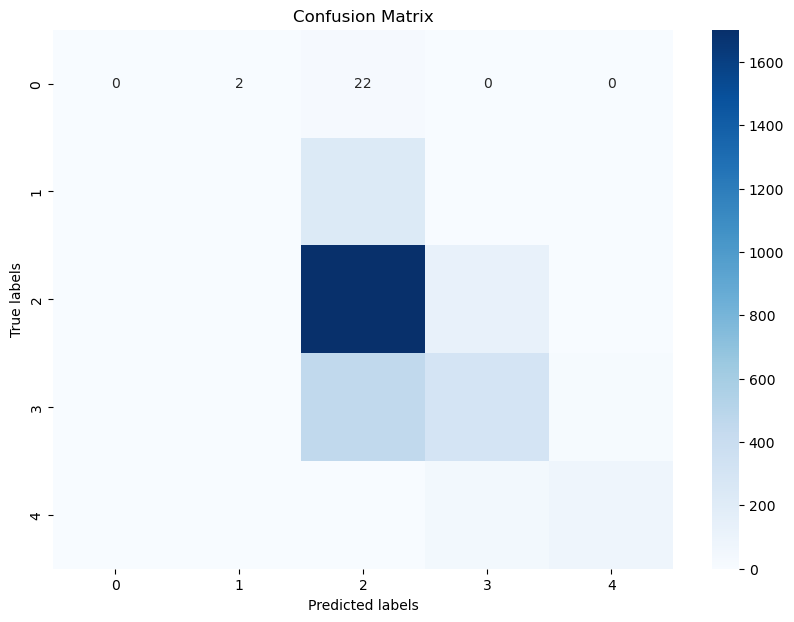

In [12]:
best_pipeline = grid_search.best_estimator_
cv_acc = cross_val_score(best_pipeline, X, y, cv=cv, scoring='accuracy')
cv_pred = cross_val_predict(best_pipeline, X, y, cv=cv)
print("Cross Val accuracy:", cv_acc)
print("Cross Val Mean accuracy:", cv_acc.mean())
print("Classification Report: \n", classification_report(y, cv_pred))
cm = confusion_matrix(y, cv_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()